# Regression Analysis - 3 - KNN Regression, Decision Tree Regression, Linear Regression

## Import libraries and load dataset

In [1]:
# Dataframe Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EDA Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

#KNN regression Import
from sklearn.neighbors import KNeighborsRegressor

# Decision Tree Regression Import
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

#Linear Regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# MSE, RMSE Calc. Import
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [2]:
# Load presaved dataset from seaborn

exp = sns.load_dataset("healthexp")

## Data Summary

In [3]:
exp.head()

,Year,Country,Spending_USD,Life_Expectancy
0,1970,Germany,252.311,70.6
1,1970,France,192.143,72.2
2,1970,Great Britain,123.993,71.9
3,1970,Japan,150.437,72.0
4,1970,USA,326.961,70.9


In [4]:
exp.tail()

,Year,Country,Spending_USD,Life_Expectancy
269,2020,Germany,6938.983,81.1
270,2020,France,5468.418,82.3
271,2020,Great Britain,5018.700,80.4
272,2020,Japan,4665.641,84.7
273,2020,USA,11859.179,77.0


In [5]:
exp.shape

(274, 4)

In [6]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             274 non-null    int64  
 1   Country          274 non-null    object 
 2   Spending_USD     274 non-null    float64
 3   Life_Expectancy  274 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 8.7+ KB


## Data Visualizations

Let's `visualise` the data to understand it better.

### Spending vs. Life_Expectancy

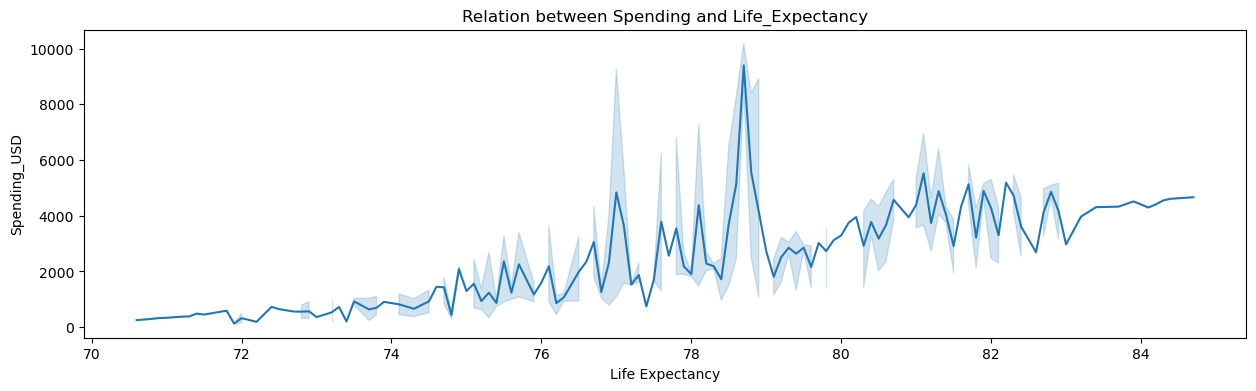

In [7]:
# Month-wise plot
plt.figure(figsize=(15, 4))
sns.lineplot(x='Life_Expectancy', y= 'Spending_USD', data=exp)

plt.title('Relation between Spending and Life_Expectancy')
plt.xlabel('Life Expectancy')
plt.ylabel('Spending_USD')
plt.show()

### Life expectancy across countries for 50 years

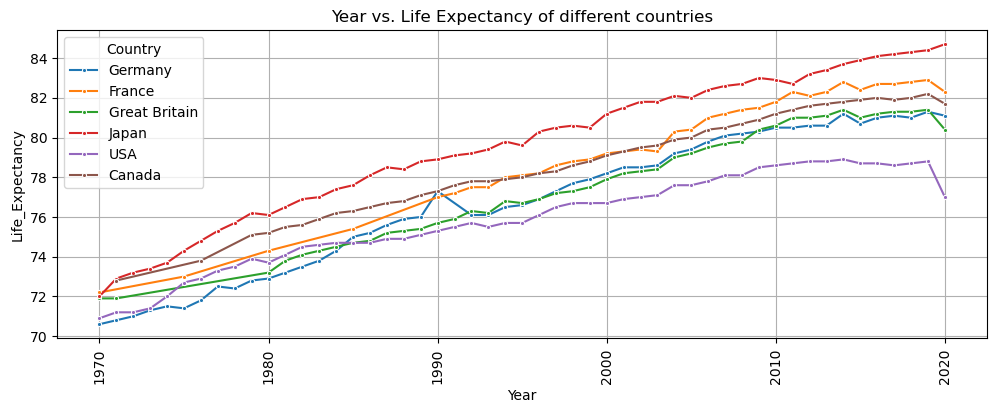

In [8]:
plt.figure(figsize=(12, 4))
sns.lineplot(x='Year', y='Life_Expectancy', hue = 'Country', data=exp, marker='.')

plt.title('Year vs. Life Expectancy of different countries')
plt.xlabel('Year')
plt.ylabel('Life_Expectancy')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [9]:
exp.columns

Index(['Year', 'Country', 'Spending_USD', 'Life_Expectancy'], dtype='object')

## Basic EDA

Let's analyse the variables, `Year` and `Spending_USD` as a numerical column, hence, not modifying the datatype of these.

## One-Hot Encoding

Let's encode the feature, `Country`, as per One-Hot Encoding, as there is no predence or sequence across the column.

In [10]:
print("Countries:", exp.Country.unique())

Countries: ['Germany' 'France' 'Great Britain' 'Japan' 'USA' 'Canada']


**We can also create n-1 dummy variables for the 6 categories using the `drop_first` parameter.**

In [11]:
exp = pd.get_dummies(exp, columns= ['Country'], drop_first = True)

# display 6 sample observations
exp.sample(6)

,Year,Spending_USD,Life_Expectancy,Country_France,Country_Germany,Country_Great Britain,Country_Japan,Country_USA
228,2013,4544.964,82.3,True,False,False,False,False
191,2007,3750.787,80.1,False,True,False,False,False
249,2016,9717.649,78.7,False,False,False,False,True
93,1990,1088.959,78.9,False,False,False,True,False
241,2015,3805.820,81.0,False,False,True,False,False
179,2005,3429.955,79.4,False,True,False,False,False


In [12]:
col_names = exp.columns.tolist()
col_names

['Year',
 'Spending_USD',
 'Life_Expectancy',
 'Country_France',
 'Country_Germany',
 'Country_Great Britain',
 'Country_Japan',
 'Country_USA']

### Missing value treatment

In [13]:
exp.isnull().values.any()

False

Let's plot a `heatmap` of missing values.

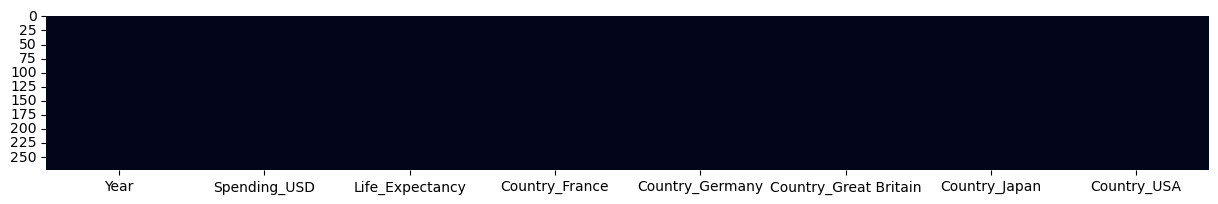

In [14]:
# set the figure size
plt.rcParams["figure.figsize"]=[15,2]

# plot a heatmap of the missing values in the data
# cbar: specify whether to display the color index or not
sns.heatmap(exp.isnull(), cbar = False)

# display the plot
plt.show()

***We have ensured that there are no missing values in the dataset.***

### Outlier Treatment

Let's check the outliers on the columns, `Spending_USD` and `Life_Expectancy`, as in the others, outliers aren't relevant to domain.

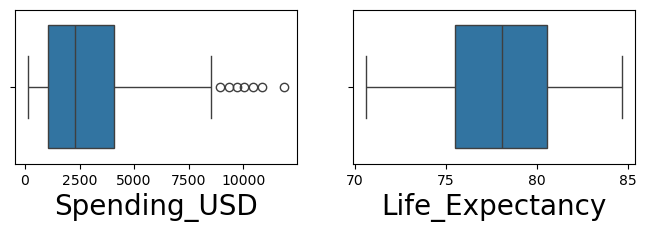

In [15]:
# let's first plot the outliers.
variables = ['Spending_USD', 'Life_Expectancy']
fig, ax = plt.subplots(1, 2, figsize=(8, 2))

for variable, subplot in zip(exp[variables], ax.flatten()):
    z = sns.boxplot(x=exp[variable], orient = "h",whis=1.5 , ax=subplot)
    z.set_xlabel(variable, fontsize = 20)
plt.show()

From the graph of `Spending_USD`, we can view that outliers exist at a particular peak, and rest of the peaks are much below, let's cap the values at this peak to the upper limit of the boxplots.

In [16]:
Q1 = exp['Spending_USD'].quantile(0.25)
Q3 = exp['Spending_USD'].quantile(0.75)
print(Q3)
print(Q1)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(upper_bound)
print(lower_bound)

4055.61
1038.357
8581.4895
-3487.5225


Let's `cap outlier values` of the column to `8580`.

In [17]:
exp.loc[exp["Spending_USD"] > 8580, "Spending_USD"] = 8580

**Let's plot the boxplot of the column again to verify that there are no outliers.**

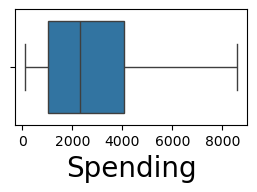

In [18]:
# let's first plot the outliers.
plt.figure(figsize=(3, 1.5))
z = sns.boxplot(x=exp['Spending_USD'], whis=1.5)  # plot the boxplot
z.set_xlabel("Spending", fontsize=20)  # set the x-axis label
plt.show()

**Now, we can observe that there are no outliers in the data.**

## Scaling & Train and Test Split

In [19]:
# select the target variable
Y = exp['Life_Expectancy']

# select all the independent variables
# by dropping the target variable
X = exp.drop(['Life_Expectancy'], axis = 1)

### Min-Max Scaling

In [20]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.sample(5)

,0,1,2,3,4,5,6
48,0.24,0.103133,0.0,0.0,0.0,0.0,0.0
23,0.12,0.049591,0.0,0.0,0.0,0.0,0.0
192,0.74,0.409677,1.0,0.0,0.0,0.0,0.0
36,0.18,0.092830,0.0,0.0,0.0,0.0,1.0
28,0.14,0.025619,0.0,0.0,0.0,1.0,0.0


In [21]:
# let us now split the dataset into train & test
# test_size: the proportion of data to be included in the testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.30, random_state=197)

# print the shape of 'x_train'
print("X_train ",X_train.shape)

# print the shape of 'x_test'
print("X_test ",X_test.shape)

# print the shape of 'y_train'
print("Y_train ",y_train.shape)

# print the shape of 'y_test'
print("Y_test ",y_test.shape)

X_train  (191, 7)
X_test  (83, 7)
Y_train  (191,)
Y_test  (83,)


## KNN Regression

In [22]:
# Train the model with different K values and plot MAPE scores
k_values = np.arange(1,20,2)
train_mape_scores = []
test_mape_scores = []

In [23]:
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_pred = knn.predict(X_train)
    test_pred = knn.predict(X_test)
    
    train_mape = mean_absolute_percentage_error(y_train, train_pred)
    test_mape = mean_absolute_percentage_error(y_test, test_pred)
    
    train_mape_scores.append(train_mape)
    test_mape_scores.append(test_mape)

In [24]:
test_mape_scores

[0.003801071443553982,
 0.0029434786972568094,
 0.003168917310863331,
 0.0036234462896350323,
 0.004504644877026015,
 0.005578456261763559,
 0.006874236787450263,
 0.008986531942948012,
 0.011183835231109107,
 0.013100570714823378]

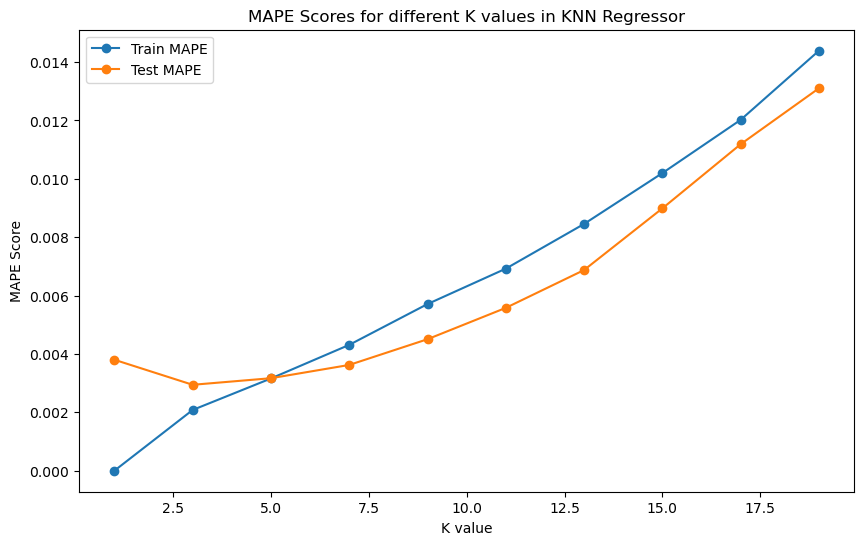

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_mape_scores, marker='o', label='Train MAPE')
plt.plot(k_values, test_mape_scores, marker='o', label='Test MAPE')
plt.xlabel('K value')
plt.ylabel('MAPE Score')
plt.title('MAPE Scores for different K values in KNN Regressor')
plt.legend()
plt.show()

Let us take k = 5, as the test and train MAPE Scores intersect at this point.

In [26]:
model = KNeighborsRegressor(n_neighbors = 5)
model.fit(X_train, y_train)  #fit the model
pred=model.predict(X_test) #make prediction on test set
error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
print('RMSE value for k= 5 is:', error)

RMSE value for k= 5 is: 0.3164715103567299


In [27]:
knn_pred = model.predict(X_test)
knn_pred

array([81.9 , 77.76, 74.1 , 81.26, 75.2 , 72.48, 79.34, 82.54, 75.58,
       81.08, 75.58, 78.3 , 73.38, 82.24, 78.36, 72.48, 81.  , 82.36,
       74.38, 78.  , 77.48, 82.14, 78.22, 79.86, 77.46, 81.06, 76.06,
       76.06, 78.38, 77.44, 77.48, 80.98, 75.68, 73.  , 72.48, 82.24,
       74.86, 78.36, 80.38, 76.6 , 78.24, 73.72, 79.52, 74.94, 75.68,
       76.42, 81.  , 71.12, 76.5 , 81.9 , 84.08, 71.5 , 81.9 , 81.9 ,
       80.  , 79.8 , 75.2 , 76.6 , 74.38, 77.58, 84.08, 77.48, 75.32,
       82.72, 73.72, 78.6 , 79.86, 81.12, 78.66, 80.68, 78.38, 79.08,
       80.28, 76.34, 77.8 , 78.76, 78.24, 77.16, 82.72, 76.14, 74.22,
       73.74, 81.34])

**Hence, on the above output, we have obtained the `Life Expectancy` values for all the test columns.**

## Decision Tree Regression

[Text(0.5405585106382979, 0.9583333333333334, 'Year <= 0.58\nsquared_error = 9.856\nsamples = 83\nvalue = 78.051'), Text(0.27992021276595747, 0.875, 'Year <= 0.31\nsquared_error = 4.232\nsamples = 43\nvalue = 75.698'), Text(0.11569148936170212, 0.7916666666666666, 'Year <= 0.1\nsquared_error = 1.54\nsamples = 20\nvalue = 73.905'), Text(0.0425531914893617, 0.7083333333333334, 'Country2 <= 0.5\nsquared_error = 0.912\nsamples = 4\nvalue = 72.35'), Text(0.02127659574468085, 0.625, 'Spending_USD <= 0.008\nsquared_error = 0.01\nsamples = 2\nvalue = 73.3'), Text(0.010638297872340425, 0.5416666666666666, 'squared_error = 0.0\nsamples = 1\nvalue = 73.2'), Text(0.031914893617021274, 0.5416666666666666, 'squared_error = -0.0\nsamples = 1\nvalue = 73.4'), Text(0.06382978723404255, 0.625, 'Year <= 0.07\nsquared_error = 0.01\nsamples = 2\nvalue = 71.4'), Text(0.05319148936170213, 0.5416666666666666, 'squared_error = 0.0\nsamples = 1\nvalue = 71.3'), Text(0.07446808510638298, 0.5416666666666666, 'squ

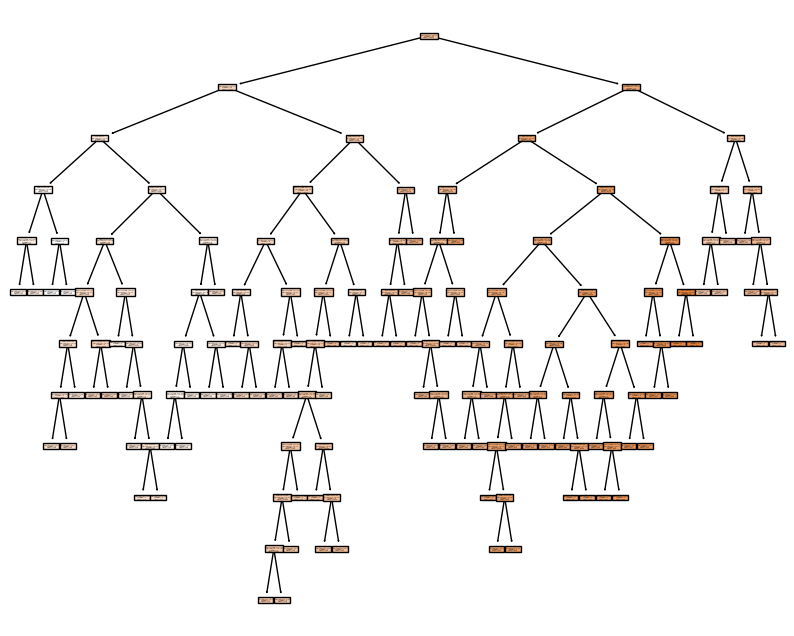

In [30]:
# Create the decision tree regression model
regressor = DecisionTreeRegressor()

# Fit the model to the data
regressor.fit(X_test, y_test)

# Display the decision tree
fig = plt.figure(figsize=(10, 8))
out = tree.plot_tree(regressor, feature_names=['Year', 'Spending_USD', 'Country1', 'Country2', 'Country3', 'Country4', 'Country5'], filled=True)
print(out)
plt.show()

In [31]:
pd.DataFrame({'features':['Year', 'Spending_USD', 'Country1', 'Country2', 'Country3', 'Country4', 'Country5'], 'importance':regressor.feature_importances_})

,features,importance
0,Year,0.825971
1,Spending_USD,0.042806
2,Country1,0.001875
3,Country2,0.012181
4,Country3,0.000618
5,Country4,0.037969
6,Country5,0.078581


In [32]:
y_pred = regressor.predict(X_test)
y_pred

array([82.3, 77.8, 74.5, 81. , 75.3, 73.2, 79.5, 83. , 75.5, 81.2, 75.6,
       78.4, 73.5, 82.3, 78.7, 72.8, 81.4, 82.7, 74.3, 78.2, 77.2, 82. ,
       78.2, 79.8, 77.8, 81. , 76.3, 76.2, 78.5, 77.1, 78.1, 81.2, 75.2,
       73.3, 72.9, 82.1, 74.7, 78. , 80.3, 76.9, 78.1, 73.4, 79.3, 75. ,
       75.6, 76.3, 81.2, 71.3, 76.7, 81.7, 84.7, 71.5, 82. , 82. , 79.3,
       79.8, 74.8, 76.5, 74.6, 77.5, 84.2, 77.3, 75.7, 82.7, 73.2, 78.6,
       79.7, 81.4, 78.8, 81.2, 78.1, 79.2, 80.4, 76.7, 77.6, 78.8, 78.8,
       77.6, 82.3, 77.3, 73.8, 74.1, 81.4])

**Hence, on the above output, we have obtained the `Life Expectancy` values for all the test columns.**

In [191]:
# Evaluation (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

In [192]:
mse

1.761369166105414

**We can observe that the MSE value is very low, hence, the predicated values are very close to the actual values.**

## Linear Regression

In [193]:
# fit regression model

lm = LinearRegression()

lm = lm.fit(X_train,y_train)

In [194]:
lm.intercept_, lm.coef_

(72.21516128509671,
 array([ 1.44333209e+01, -5.49942452e+00,  1.03692225e-02, -1.07795367e+00,
        -1.58137276e+00,  1.26769552e+00, -1.03124042e+00]))

In [195]:
lm.score(X_train, y_train)

0.9794165007599492

From the lm.score, we can observe that there is linear dependency between X columns and y, though not too high, so, Linear Regression can be used predict in this dataset.

In [196]:
yhat = lm.predict(X_train)
yhat

array([80.27632917, 75.36263877, 75.61751263, 80.90243088, 75.46294621,
       78.72924913, 79.61492031, 83.04904793, 80.80958635, 81.8838018 ,
       74.56076407, 78.50055799, 77.130556  , 74.41658256, 72.09722535,
       75.35469858, 73.67443643, 80.2555372 , 76.8640672 , 75.66443525,
       84.04830986, 75.96046325, 78.64557801, 81.22209007, 72.34320493,
       83.08988375, 79.88792893, 71.05375509, 79.82915084, 71.05191918,
       79.92651814, 80.05858044, 76.25523718, 76.14855584, 80.98756466,
       77.96062786, 80.76154649, 80.62437559, 78.75694847, 77.94766688,
       76.96366923, 78.67448517, 76.59515109, 76.90672459, 80.13466863,
       78.82680568, 75.2088092 , 83.61676128, 81.87994002, 71.58363857,
       79.04133814, 80.76356102, 77.04424795, 76.32030088, 77.99061475,
       75.43948626, 71.32040697, 73.74559934, 81.13835113, 81.82818587,
       72.38065136, 82.27119915, 81.84560982, 74.82195225, 79.86091295,
       75.71801192, 77.11967232, 78.86689524, 79.09628111, 72.31

In [197]:
lm.intercept_ + lm.coef_ * X_train

,0,1,2,3,4,5,6
217,84.050484,70.022379,72.215161,72.215161,70.633789,72.215161,72.215161
80,77.411157,71.244597,72.215161,71.137208,72.215161,72.215161,72.215161
31,74.524493,72.040486,72.215161,72.215161,72.215161,73.482857,72.215161
251,85.782483,68.413063,72.215161,71.137208,72.215161,72.215161,72.215161
81,77.411157,71.848323,72.215161,72.215161,70.633789,72.215161,72.215161
...,...,...,...,...,...,...,...
207,83.473152,67.323819,72.215161,72.215161,72.215161,72.215161,71.183921
137,80.297821,70.626983,72.215161,71.137208,72.215161,72.215161,72.215161
78,77.122490,71.010587,72.215161,72.215161,72.215161,72.215161,71.183921
36,74.813159,71.704650,72.215161,72.215161,72.215161,72.215161,71.183921


In [198]:
np.corrcoef(y_train, yhat)**2

array([[1.       , 0.9794165],
       [0.9794165, 1.       ]])

In [199]:
error = y_train - yhat
error

217    0.723671
80     0.537361
31     0.082487
251    0.197569
81    -0.162946
         ...   
207    0.949431
137    0.068311
78     0.013324
36     0.628592
273   -3.117817
Name: Life_Expectancy, Length: 191, dtype: float64

In [200]:
abs_error = np.abs(error)
mae = np.mean(abs_error) # mean absolute error
mae

0.3385060446942466

In [201]:
# calculate mean of absolute percentage error
np.mean(np.abs(error / y_train)) * 100

0.43873468413627237

In [202]:
# sum of squares of error
sse = np.sum(error ** 2)

In [203]:
# sum of squares total
sst = np.sum((y_train - y_train.mean())**2)

In [204]:
1- (sse/sst)

0.9794165007599492

In [205]:
# predicting for a new value of X
# say 2020

lm.intercept_ + lm.coef_ * 2020

array([ 29227.52340638, -11036.62236915,     93.16099069,  -2105.25124704,
        -3122.1578174 ,   2632.96010775,  -2010.89048388])

In [206]:
# plot the regression line

X_min = X_train.min()
yhat_min = lm.intercept_ + lm.coef_ * X_min
X_max = X_train.max()
yhat_max = lm.intercept_ + lm.coef_ * X_max

In [207]:
# fit statsmodels OLS regression model
X = sm.add_constant(X_train)

In [208]:
X

,const,0,1,2,3,4,5,6
217,1.0,0.82,0.398729,0.0,0.0,1.0,0.0,0.0
80,1.0,0.36,0.176485,0.0,1.0,0.0,0.0,0.0
31,1.0,0.16,0.031763,0.0,0.0,0.0,1.0,0.0
251,1.0,0.94,0.691363,0.0,1.0,0.0,0.0,0.0
81,1.0,0.36,0.066705,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
207,1.0,0.78,0.889428,0.0,0.0,0.0,0.0,1.0
137,1.0,0.56,0.288790,0.0,1.0,0.0,0.0,0.0
78,1.0,0.34,0.219036,0.0,0.0,0.0,0.0,1.0
36,1.0,0.18,0.092830,0.0,0.0,0.0,0.0,1.0


In [209]:
# Prediction
y_pred = lm.predict(X_test)
y_pred

array([81.43490338, 77.67936119, 73.86379789, 81.22927487, 75.36263161,
       73.73325211, 79.73939914, 82.8890306 , 75.76645176, 81.1398798 ,
       75.1119864 , 78.12913276, 74.00252813, 81.76297644, 79.54048442,
       73.2951022 , 80.85008279, 82.71234203, 74.14066184, 77.99470934,
       77.52810442, 82.05966772, 78.31869041, 79.59750205, 77.41243816,
       80.48794193, 76.45980142, 76.70617706, 78.20934235, 77.06625753,
       77.62294639, 81.02176827, 74.93478337, 72.81290951, 73.51387929,
       81.63399221, 74.46608578, 78.22153897, 79.77147968, 77.03393699,
       78.15648368, 74.2956666 , 79.38486123, 74.70331911, 75.16258546,
       75.83701164, 80.65319867, 71.83375762, 77.21957589, 82.93862981,
       84.96248452, 72.07806773, 82.293876  , 82.69946187, 79.84449828,
       79.56780719, 75.09796532, 76.72242033, 74.07294124, 77.58300141,
       84.26088839, 77.77466346, 75.97877932, 82.37978225, 74.02025966,
       77.68688889, 79.42992043, 82.00696558, 78.38398321, 80.56

**Hence, on the above output, we have obtained the `Life Expectancy` values for all the test columns.**

In [210]:
# Evaluation (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
mse

0.2352357637839746

**We can observe that the MSE value is very low, hence, the predicated values are very close to the actual values.**